In [ ]:
import pandas as pd
import numpy as np
import math

In [ ]:
train = np.genfromtxt('./train_timeseries.csv', delimiter=',')
test = np.genfromtxt('./test_timeseries.csv', delimiter=',')

In [ ]:
train.shape

In [ ]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [ ]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

# Reducing complexity of DTW

In [ ]:
# Dynamic time warping has a complexity of O(nm) where n is the length of the first time series and m is the length of the second time series.
# If you are performing dynamic time warping multiple times on long time series data, this can be prohibitively expensive. 
# However, there are a couple of ways to speed things up. The first is to enforce a locality constraint.
# This works under the assumption that it is unlikely for qi and cj to be matched if i and j are too far apart. 
# The threshold is determined by a window size w. This way, only mappings within this window are considered which speeds up the inner loop. 
# The following is the modified code which includes the window size w.

In [ ]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return math.sqrt(LB_sum)

# Classify and Cluster

In [ ]:
# Now that we have a reliable method to determine the similarity between two time series,
# we can use the k-NN algorithm for classification. Empirically, the best results have come when k=1. 
# The following is the 1-NN algorithm that uses dynamic time warping Euclidean distance.
# In this algorithm, train is the training set of time series examples
# where the class that the time series belongs to is appended to the end of the time series. test is the test set whose corresponding classes 
# you are trying to predict. In this algorithm, for every time series in the test set,
# a search must be performed through all points in the training set so that the most similar point is found.
# Given that dynamic time warping is quadratic, this can be very computationally expensive.
# We can speed up classification using the LB Keogh lower bound. Computing LB Keogh is much less expensive than performing dynamic time warping. And since LBKeogh(Q,C)≤DTW(Q,C) , we can eliminate time series that cannot possibly be more similar that the current most similar time series.
# In this way we are eliminating many unnecessary dynamic time warping computations.

In [ ]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [40]:
print (knn(train,test,4))

              precision    recall  f1-score   support

         1.0       1.00      0.96      0.98        50
         2.0       0.96      1.00      0.98        50
         3.0       1.00      1.00      1.00        50
         4.0       0.98      1.00      0.99        50
         5.0       1.00      1.00      1.00        50
         6.0       1.00      0.98      0.99        50

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [43]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print (counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

1
2
3
4
5
6
7
8
9
10


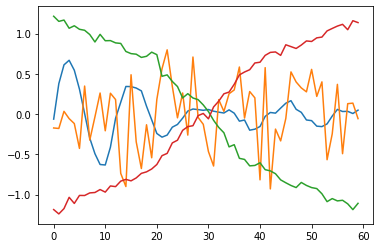

In [52]:
data=np.vstack((train[:,:-1],test[:,:-1]))

import matplotlib.pylab as plt

centroids=k_means_clust(list(data),4,10,4)
for i in centroids:
    
    plt.plot(i)

plt.show()